In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-dataset/Wine.csv
/kaggle/input/wineuci/Wine.csv


# Wine Classification

There are 3 types of wines in this dataset.

Scope of the project is to find the type of wine given data

Feature present in the dataset are:
1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
#importing dataset
wine_data = pd.read_csv('../input/wine-dataset/Wine.csv')

In [4]:
wine_data.head()

,Types,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Totally there are 13 features and one target variable(Types)

## Exploratory Data Analysis

In [5]:
wine_data.shape

(178, 14)

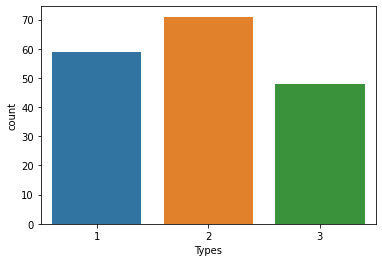

In [6]:
#Let's check the class count of target
sns.countplot(x='Types',data=wine_data);

In [7]:
wine_data['Types'].value_counts()

2    71
1    59
3    48
Name: Types, dtype: int64

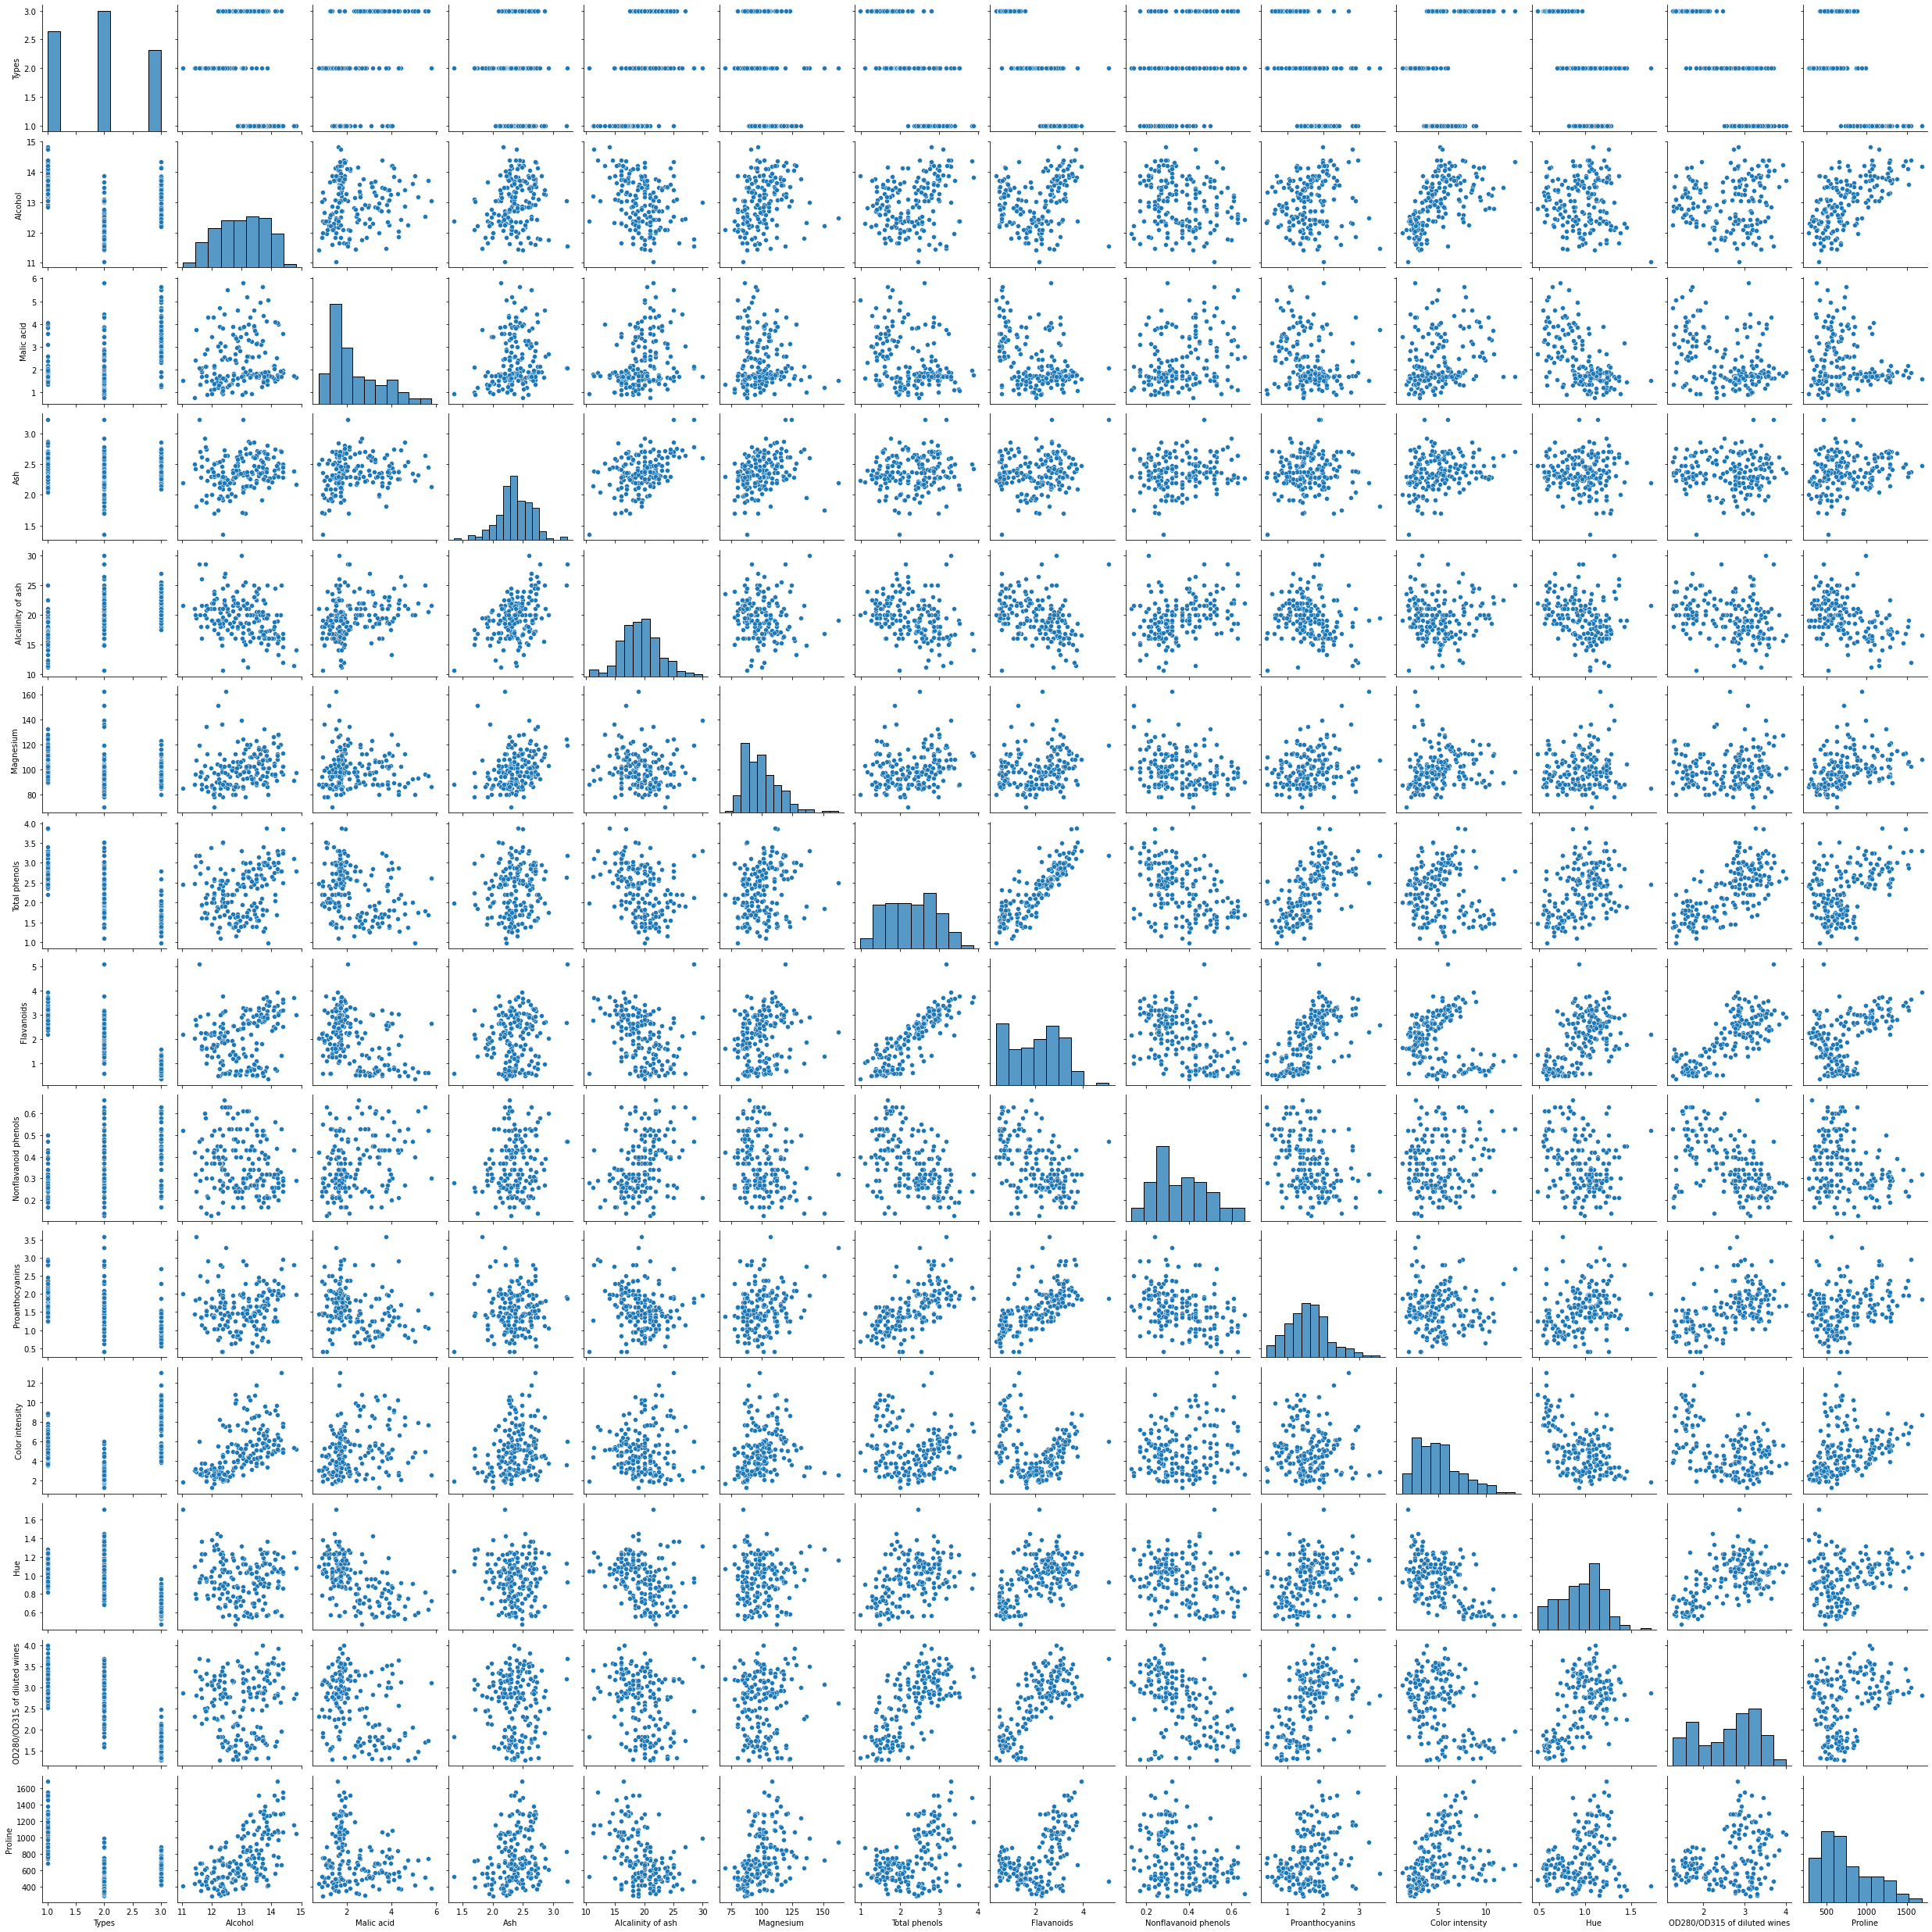

In [8]:
#Let's check distribution of the each feature
sns.pairplot(data=wine_data,palette='rainbow');

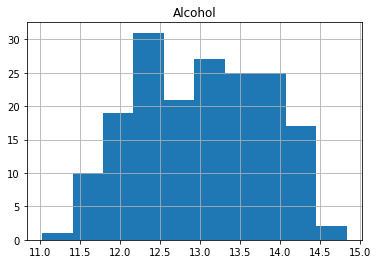

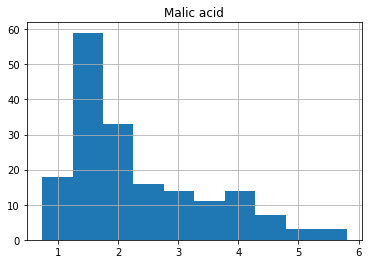

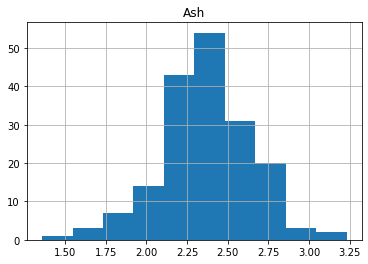

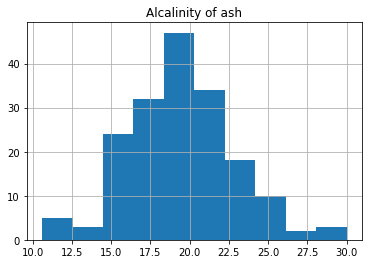

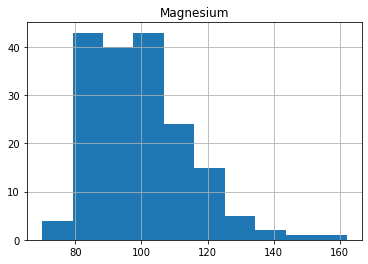

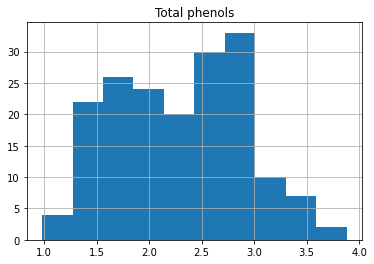

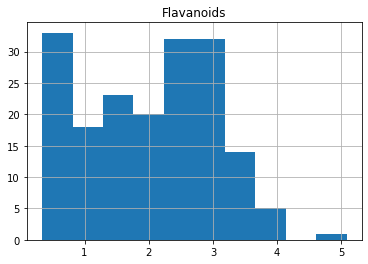

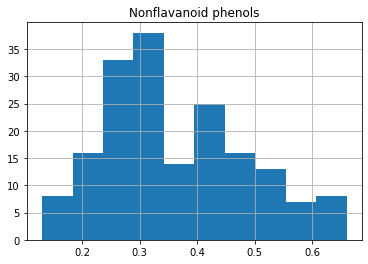

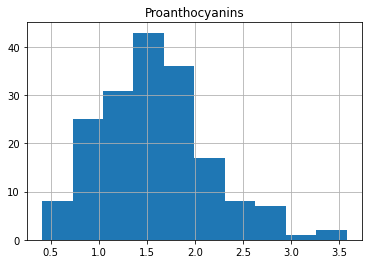

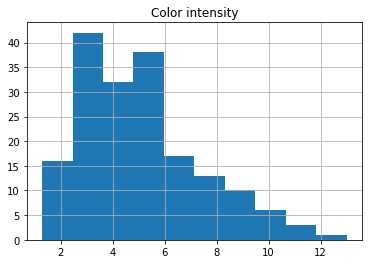

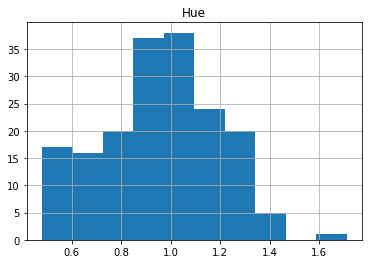

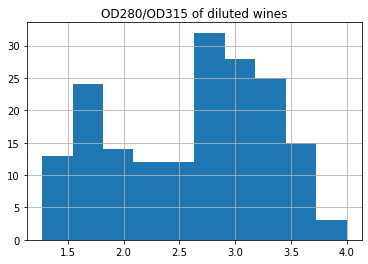

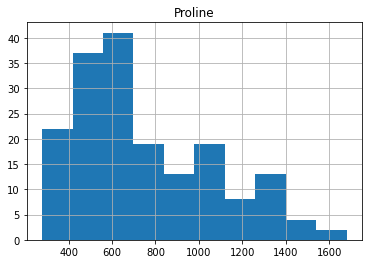

In [9]:
# Distribution plots of all features in the dataset
wine_columns = list(wine_data.columns[1:])

for i in wine_columns:
    wine_data[i].hist()
    plt.title(i)
    plt.show()


**From Above we infer that data follows standard normal/Gaussian distribution but some of the
features are skewed although it is gaussian distributed**

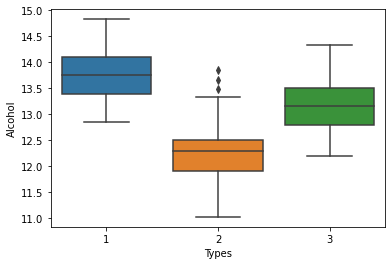

In [10]:
# Let's check is there any outliers in the data with respect to types of wine
sns.boxplot(x='Types',y='Alcohol',data=wine_data);

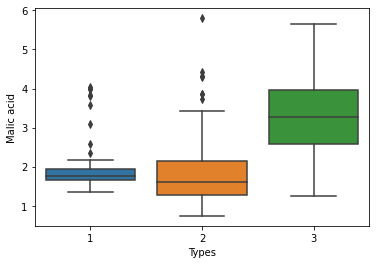

In [11]:
sns.boxplot(x='Types',y='Malic acid',data=wine_data);

In [12]:
wine_data.columns

Index(['Types', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
       'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')

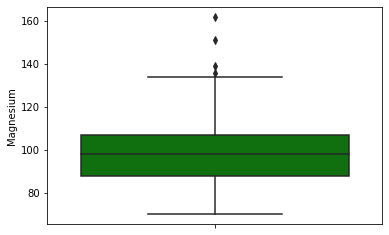

In [13]:
# Univariate outliers
sns.boxplot(y='Magnesium',data=wine_data,color='green');

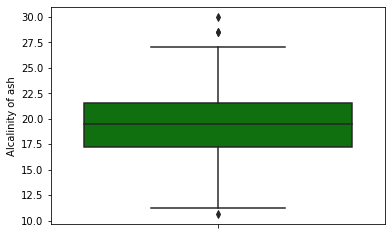

In [14]:
sns.boxplot(y='Alcalinity of ash',data=wine_data,color='green');

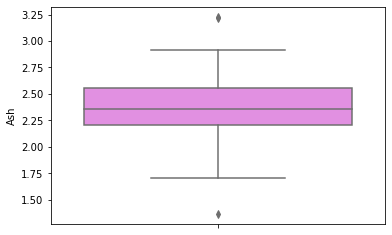

In [15]:
sns.boxplot(y='Ash',data=wine_data,color='violet');

From above plots, we infer that there are both univariate and multivariate outliers present in the data.
So we have to treat the outliers before modelling

In [16]:
#Let's check correlation relation between features
wine_data.corr()

,Types,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Types,1.000000,-0.328222,0.437776,-0.049643,0.517859,-0.209179,-0.719163,-0.847498,0.489109,-0.499130,0.265668,-0.617369,-0.788230,-0.633717
Alcohol,-0.328222,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic acid,0.437776,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,-0.049643,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Alcalinity of ash,0.517859,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Magnesium,-0.209179,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Total phenols,-0.719163,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,-0.847498,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid phenols,0.489109,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanthocyanins,-0.499130,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417


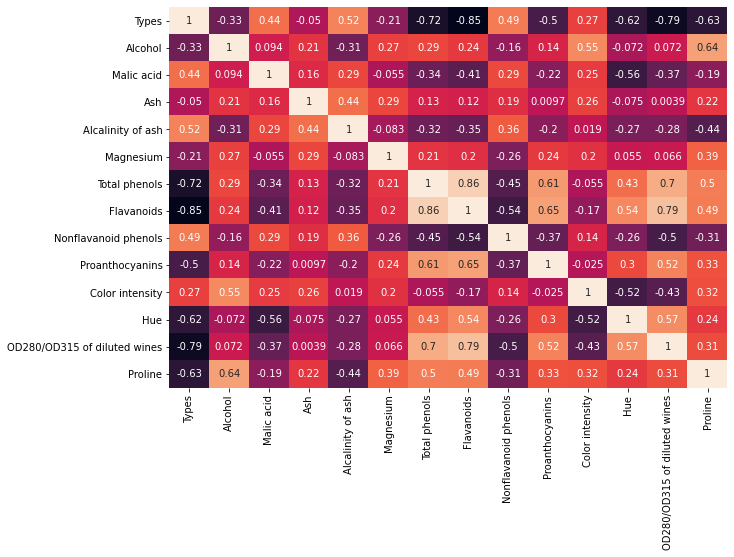

In [17]:
#Visualizing correlation matrix in sophistic way
plt.figure(figsize=(10,7))
sns.heatmap(wine_data.corr(),cbar=False,cmap='rocket',annot=True);

*From correlation matrix, it is found that there are no greater linear relationship 
between independent variables and target variable*

## Data Cleaning

In [18]:
wine_data.dtypes

Types                             int64
Alcohol                         float64
Malic acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                         int64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                           int64
dtype: object

All the types of features are integer or float, So we need to not worry about categorical data types

In [19]:
# Let's find any missing values in the dataset
wine_data.isnull().sum()

Types                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

There are no missing values in the dataset

## Modelling

In [20]:
# Separating independent and dependent variables
X = wine_data.drop('Types',axis=1)
y = wine_data['Types']


In [21]:
# Splitting the data into train and test dataset
np.random.seed(42)
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

print('After splitting the data ')
print('Shape of train set: ',X_train.shape)
print('Shape of test set: ',X_test.shape)

After splitting the data 
Shape of train set:  (142, 13)
Shape of test set:  (36, 13)


In [22]:
# Let's try Logistic Regression model
np.random.seed(42)

from sklearn.linear_model import LogisticRegression

base_model = LogisticRegression(max_iter=5000)

base_model.fit(X_train,y_train)
base_model.score(X_test,y_test)

0.9444444444444444

## Evaluation of the model

In [23]:
def evaluation_metrics(model):
    y_preds = model.predict(X_test)
    print('Model accuarcy score: ',accuracy_score(y_test,y_preds))
    print('Model Cross validation score: ',np.mean(cross_val_score(model,X,y,cv=5)))
    print('confusion Matrix \n',confusion_matrix(y_test,y_preds))
    

In [24]:
# Lets evaluate the model
evaluation_metrics(base_model)

Model accuarcy score:  0.9444444444444444
Model Cross validation score:  0.961111111111111
confusion Matrix 
 [[12  0  0]
 [ 0 14  0]
 [ 0  2  8]]


Since data follows standard Gaussian distribution and each feature is in different scales, we will apply
Standardization to the data and again apply ML algorithm to the data

## Standardization process

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [26]:
# Splitting the data into train and test dataset
np.random.seed(42)
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,stratify=y)

print('After splitting the data ')
print('Shape of train set: ',X_train.shape)
print('Shape of test set: ',X_test.shape)

After splitting the data 
Shape of train set:  (142, 13)
Shape of test set:  (36, 13)


In [27]:
# Let's try Logistic Regression model again
np.random.seed(42)

from sklearn.linear_model import LogisticRegression

std_model = LogisticRegression(max_iter=5000)

std_model.fit(X_train,y_train)
std_model.score(X_test,y_test)

0.9722222222222222

In [28]:
print('Evalaution Metric of the model after applying Standardization...')
evaluation_metrics(std_model)

Evalaution Metric of the model after applying Standardization...
Model accuarcy score:  0.9722222222222222
Model Cross validation score:  0.961111111111111
confusion Matrix 
 [[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]
